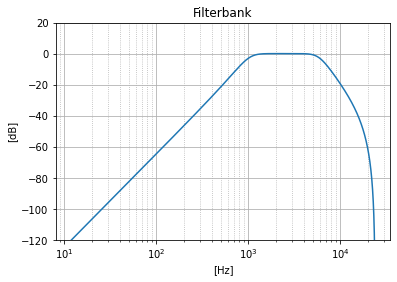

In [18]:
import octafilt3r.filter as o3f
import octafilt3r.plot as o3p
import numpy as np
from numpy import pi, log10, logspace
from scipy.signal import zpk2tf, zpk2sos, freqs, sosfilt

sos = o3f._gen_bandpass(48000, 1000, 6000, 6, True)



C:\users\j.tschavoll\appdata\local\programs\python\python39\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


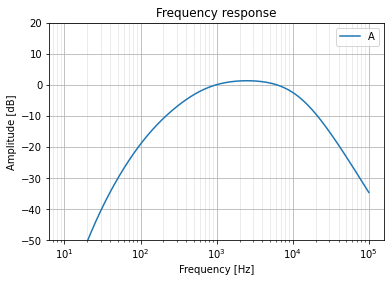

In [30]:
def ABC_weighting(curve='A'):
    """
    Design of an analog weighting filter with A, B, or C curve.
    Returns zeros, poles, gain of the filter.
    Examples
    --------
    Plot all 3 curves:
    >>> from scipy import signal
    >>> import matplotlib.pyplot as plt
    >>> for curve in ['A', 'B', 'C']:
    ...     z, p, k = ABC_weighting(curve)
    ...     w = 2*pi*logspace(log10(10), log10(100000), 1000)
    ...     w, h = signal.freqs_zpk(z, p, k, w)
    ...     plt.semilogx(w/(2*pi), 20*np.log10(h), label=curve)
    >>> plt.title('Frequency response')
    >>> plt.xlabel('Frequency [Hz]')
    >>> plt.ylabel('Amplitude [dB]')
    >>> plt.ylim(-50, 20)
    >>> plt.grid(True, color='0.7', linestyle='-', which='major', axis='both')
    >>> plt.grid(True, color='0.9', linestyle='-', which='minor', axis='both')
    >>> plt.legend()
    >>> plt.show()
    """
    if curve not in 'ABC':
        raise ValueError('Curve type not understood')

    # ANSI S1.4-1983 C weighting
    #    2 poles on the real axis at "20.6 Hz" HPF
    #    2 poles on the real axis at "12.2 kHz" LPF
    #    -3 dB down points at "10^1.5 (or 31.62) Hz"
    #                         "10^3.9 (or 7943) Hz"
    #
    # IEC 61672 specifies "10^1.5 Hz" and "10^3.9 Hz" points and formulas for
    # derivation.  See _derive_coefficients()

    z = [0, 0]
    p = [-2*pi*20.598997057568145,
         -2*pi*20.598997057568145,
         -2*pi*12194.21714799801,
         -2*pi*12194.21714799801]
    k = 1

    if curve == 'A':
        # ANSI S1.4-1983 A weighting =
        #    Same as C weighting +
        #    2 poles on real axis at "107.7 and 737.9 Hz"
        #
        # IEC 61672 specifies cutoff of "10^2.45 Hz" and formulas for
        # derivation.  See _derive_coefficients()

        p.append(-2*pi*107.65264864304628)
        p.append(-2*pi*737.8622307362899)
        z.append(0)
        z.append(0)

    elif curve == 'B':
        # ANSI S1.4-1983 B weighting
        #    Same as C weighting +
        #    1 pole on real axis at "10^2.2 (or 158.5) Hz"

        p.append(-2*pi*10**2.2)  # exact
        z.append(0)

    # TODO: Calculate actual constants for this
    # Normalize to 0 dB at 1 kHz for all curves
    b, a = zpk2tf(z, p, k)
    k /= abs(freqs(b, a, [2*pi*1000])[1][0])

    return np.array(z), np.array(p), k

from scipy import signal
import matplotlib.pyplot as plt
z, p, k = ABC_weighting()
w = 2*pi*logspace(log10(10), log10(100000), 1000)
w, h = signal.freqs_zpk(z, p, k, w)
plt.semilogx(w/(2*pi), 20*np.log10(h), label="A")
plt.title('Frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.ylim(-50, 20)
plt.grid(True, color='0.7', linestyle='-', which='major', axis='both')
plt.grid(True, color='0.9', linestyle='-', which='minor', axis='both')
plt.legend()
plt.show()




[2.35580497e-11+0.00000000e+00j 2.35570580e-11+2.16206318e-13j
 2.35540831e-11+4.32394452e-13j ... 2.43718885e-11-6.75060530e-13j
 2.43770838e-11-4.50072358e-13j 2.43802011e-11-2.25045780e-13j]


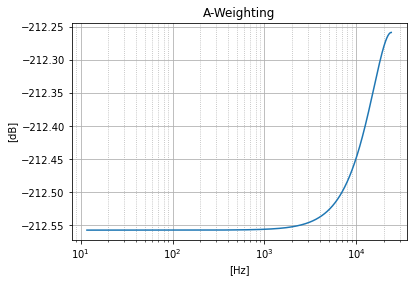

In [29]:
asos = signal.zpk2sos(z, p, k)

h, f = signal.sosfreqz(asos, worN=2048, fs=48000)
print(f)
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlabel('[Hz]')
plt.ylabel('[dB]')
plt.title("A-Weighting")
plt.semilogx(h[1:], np.array([20 * np.log10(abs(value)) for value in f[1:]]), label=None)
# plt.ylim(-120, 20)       